In [27]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import lightning as L

import torch._dynamo
torch._dynamo.config.suppress_errors = True

TORCH_LOGS="+dynamo"
TORCHDYNAMO_VERBOSE=1

In [15]:
# Define a simple LightningModule
class LitModel(L.LightningModule):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 10)
        )
        self.loss_fn = nn.CrossEntropyLoss()

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("train_loss", loss, prog_bar=True)
        self.log("train_acc", acc, prog_bar=True)
        return loss
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        preds = self(x)
        loss = self.loss_fn(preds, y)
        acc = (preds.argmax(dim=1) == y).float().mean()
        self.log("val_loss", loss, prog_bar=True)
        self.log("val_acc", acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

In [16]:
# Load dataset
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.MNIST(root="data", train=True, download=True, transform=transform)
train_set, val_set = random_split(dataset, [55000, 5000])
train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=3, persistent_workers=True)
val_loader = DataLoader(val_set, batch_size=64, num_workers=3, persistent_workers=True)

# Instantiate the model and compile it (PyTorch 2.x required)
model = LitModel()
# model = torch.compile(model, fullgraph=True)  # 🔥 Boost performance with TorchDynamo

In [17]:
# Create Lightning Trainer
trainer = L.Trainer(
    accelerator="mps",          # Automatically uses your RTX 3070
    precision="16-mixed",       # AMP for faster training & lower memory use
    max_epochs=5,
    log_every_n_steps=10
)

# Fit the model
trainer.fit(model, train_loader, val_loader)

Using 16bit Automatic Mixed Precision (AMP)
/Users/namtipyass/miniconda3/envs/deep_torch/lib/python3.10/site-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type             | Params | Mode 
-----------------------------------------------------
0 | model   | Sequential       | 101 K  | train
1 | loss_fn | CrossEntropyLoss | 0      | train
-----------------------------------------------------
101 K     Trainable params
0         Non-trainable params
101 K     Total params
0.407     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/namtipyass/miniconda3/envs/deep_torch/lib/python3.10/site-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [20]:
history = pd.read_csv(r"lightning_logs/version_7/metrics.csv")
history

,epoch,step,train_acc,train_loss
0,0,9,0.453125,1.956242
1,0,19,0.531250,1.688611
2,0,29,0.875000,1.143036
3,0,39,0.843750,0.840377
4,0,49,0.796875,0.704320
...,...,...,...,...
430,4,4269,0.984375,0.033336
431,4,4279,0.984375,0.040211
432,4,4289,0.968750,0.106116
433,4,4299,0.958333,0.057288


/var/folders/ws/vpvswwss4q30qp32967nxcs40000gn/T/ipykernel_10618/973577811.py:6: UserWarning: Legend does not support handles for Axes instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/users/explain/axes/legend_guide.html#controlling-the-legend-entries
  ax.legend([acc_axs.axes, loss_axs.axes], ['accuracy', 'loss'])


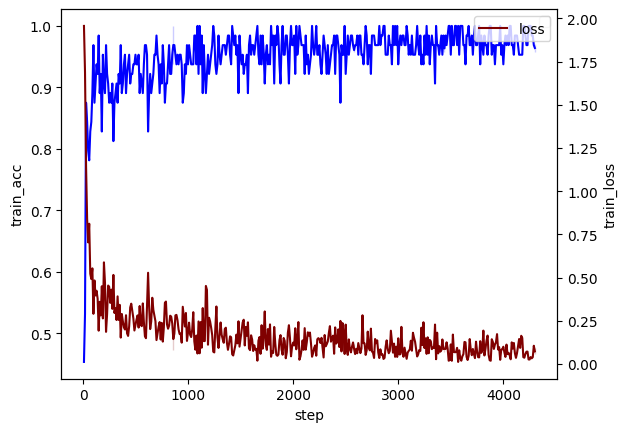

In [46]:
fig, ax = plt.subplots()

acc_axs = sns.lineplot(data=history, x='step', y='train_acc', color='blue', ax=ax, label="accuracy")
loss_axs = sns.lineplot(data=history, x='step', y='train_loss', color='maroon', ax=ax.axes.twinx(), label='loss')
# plt.legend(['accuracy', 'loss'])
ax.legend([acc_axs.axes, loss_axs.axes], ['accuracy', 'loss'])
# fig.legend()


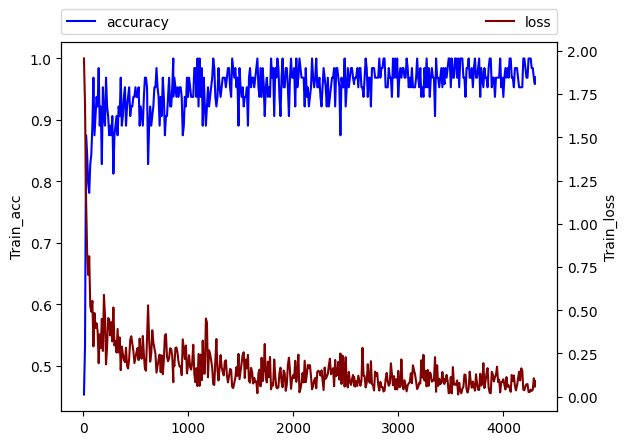

In [69]:
fig, ax = plt.subplots()

acc_axs = ax.plot(history['step'], history['train_acc'], color='blue', label="accuracy")
ax2 = ax.twinx()
loss_axs = ax2.plot(history['step'], history['train_loss'], color='maroon', label='loss')

ax.set_ylabel("Train_acc")
ax2.set_ylabel("Train_loss")

# added these three lines
lns = acc_axs + loss_axs
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)

# fig.legend(loc=1, ncols=2)



In [85]:
def convert_img_tensor2numpy(img:torch.Tensor):
    if len(img.shape) == 4:
        img = img.permute(0, 2, 3, 1)
    elif len(img.shape) == 3:
        img = img.permute(1, 2, 0)
    
    return img.numpy()

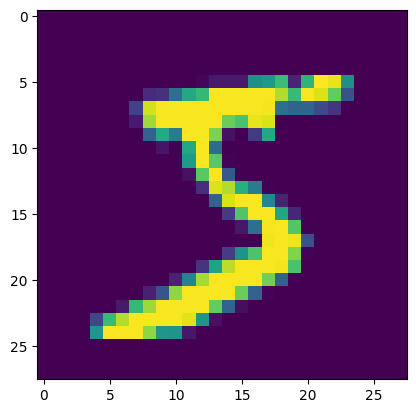

In [86]:
ori_img = dataset[0][0]
img = convert_img_tensor2numpy(ori_img)
plt.imshow(img)

In [100]:
def show(img: torch.Tensor
         ) -> None:
    img = img.clone()
    min, max = img.min(), img.max()
    img.clamp_(min=min, max=max)
    img.add_(-min).div_(max-min+1e-5)
    
    plt.imshow(img.permute(1, 2, 0).numpy(), interpolation='nearest')
    plt.xticks([])
    plt.yticks([])

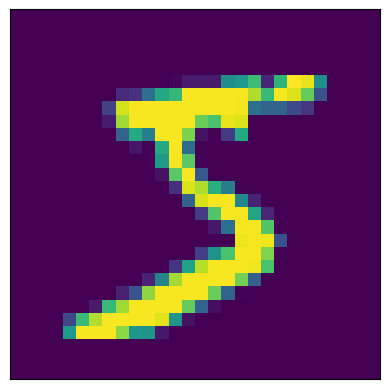

In [102]:
show(ori_img)

In [107]:
import torch
from torch import nn
from torchvision.transforms import v2
# from torchvision.transforms.v2 import Transform

class FourierTransform(v2.Transform):
    def __init__(self, shift=True, return_abs=True):
        super().__init__()
        self.shift = shift
        self.return_abs = return_abs

    def transform(self, inpt, params):
        # Assumes input is a 2D or 3D tensor (C, H, W) or (H, W)
        x = torch.fft.fft2(inpt)
        if self.shift:
            x = torch.fft.fftshift(x)
        return x.abs() if self.return_abs else x
    
class FourierTransform_1(nn.Module):
    def __init__(self, shift=True, return_abs=True):
        super(FourierTransform_1, self).__init__()
        self.shift = shift
        self.return_abs = return_abs

    def forward(self, inpt):
        # Assumes input is a 2D or 3D tensor (C, H, W) or (H, W)
        x = torch.fft.fft2(inpt)
        if self.shift:
            x = torch.fft.fftshift(x)
        return x.abs() if self.return_abs else x

In [109]:
com_transformer = FourierTransform_1()
new_transformer = FourierTransform()

In [115]:
(new_transformer(ori_img) == com_transformer(ori_img)).all()

tensor(True)

tensor([[[1.2667e+00, 1.2992e+00, 1.5894e+00, 8.9025e-01, 8.8807e-01,
          9.9395e-01, 9.4968e-01, 1.9980e+00, 8.5393e-01, 1.1355e+00,
          1.5208e+00, 3.1961e+00, 2.0278e+00, 2.1026e+00, 1.0471e+00,
          2.1026e+00, 2.0278e+00, 3.1961e+00, 1.5208e+00, 1.1355e+00,
          8.5393e-01, 1.9980e+00, 9.4968e-01, 9.9395e-01, 8.8807e-01,
          8.9025e-01, 1.5894e+00, 1.2992e+00],
         [1.3133e+00, 8.3950e-01, 4.5367e-01, 8.1918e-01, 8.3395e-01,
          8.3442e-01, 9.7053e-01, 2.9387e+00, 4.7082e+00, 2.7953e+00,
          1.9640e+00, 1.2324e+00, 3.3856e+00, 4.8916e+00, 1.8277e+00,
          1.5321e+00, 4.0916e+00, 2.2703e+00, 2.0870e+00, 9.2424e-01,
          3.1687e+00, 2.5559e+00, 1.4620e-01, 5.8497e-01, 3.7525e-01,
          6.8286e-01, 1.7243e+00, 1.9228e+00],
         [1.5655e+00, 1.5452e+00, 3.9451e-01, 1.1421e+00, 7.8975e-01,
          9.0424e-01, 1.0234e+00, 3.0268e+00, 3.3637e+00, 1.2110e+00,
          2.1384e+00, 2.3143e+00, 5.8856e+00, 3.4839e+00, 2.1753e+

In [116]:
import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from torchvision.io import read_image
from torchvision.transforms import Resize
from torchvision.transforms.functional import to_pil_image

class FourierProcessor:
    def __init__(self, filter_type=None, radius_ratio=0.1):
        """
        :param filter_type: None, "lowpass", or "highpass"
        :param radius_ratio: Radius of the filter as a fraction of image size
        """
        self.filter_type = filter_type
        self.radius_ratio = radius_ratio

    def fft2_rgb(self, img):
        # Apply 2D FFT on each channel
        return torch.fft.fftshift(torch.fft.fft2(img))

    def ifft2_rgb(self, fft_img):
        # Inverse FFT with shift back
        return torch.fft.ifft2(torch.fft.ifftshift(fft_img)).real

    def create_frequency_mask(self, shape, radius_ratio, highpass=False):
        # Create a circular frequency mask
        C, H, W = shape
        y, x = torch.meshgrid(torch.linspace(-1, 1, H), torch.linspace(-1, 1, W), indexing='ij')
        r = torch.sqrt(x**2 + y**2)
        mask = r > radius_ratio if highpass else r < radius_ratio
        return mask.float().unsqueeze(0).repeat(C, 1, 1)

    def process(self, img_tensor):
        """
        :param img_tensor: (C, H, W) image tensor in [0, 1]
        :return: original, magnitude_spectrum, reconstructed
        """
        img = img_tensor.clone()

        # FFT
        fft = self.fft2_rgb(img)

        # Magnitude for visualization
        magnitude = torch.log1p(fft.abs())

        # Apply frequency filter if specified
        if self.filter_type in ["lowpass", "highpass"]:
            mask = self.create_frequency_mask(fft.shape, self.radius_ratio,
                                               highpass=(self.filter_type == "highpass")).to(img.device)
            fft = fft * mask

        # iFFT
        img_reconstructed = self.ifft2_rgb(fft).clamp(0, 1)

        return img, magnitude / magnitude.max(), img_reconstructed

    def visualize(self, original, magnitude, reconstructed):
        plt.figure(figsize=(12, 4))
        titles = ["Original Image", "FFT Magnitude Spectrum", "Reconstructed Image"]
        for i, img in enumerate([original, magnitude, reconstructed]):
            plt.subplot(1, 3, i + 1)
            plt.title(titles[i])
            plt.imshow(to_pil_image(img))
            plt.axis("off")
        plt.tight_layout()
        plt.show()


In [117]:
# Load an RGB image and resize it
img = read_image(r"/Users/namtipyass/Downloads/Pee/AjAof_works/DR_lesion_segmentation/A. Segmentation/1. Original Images/a. Training Set/IDRiD_01.jpg").float() / 255.0  # shape (3, H, W)
img = Resize((256, 256))(img)

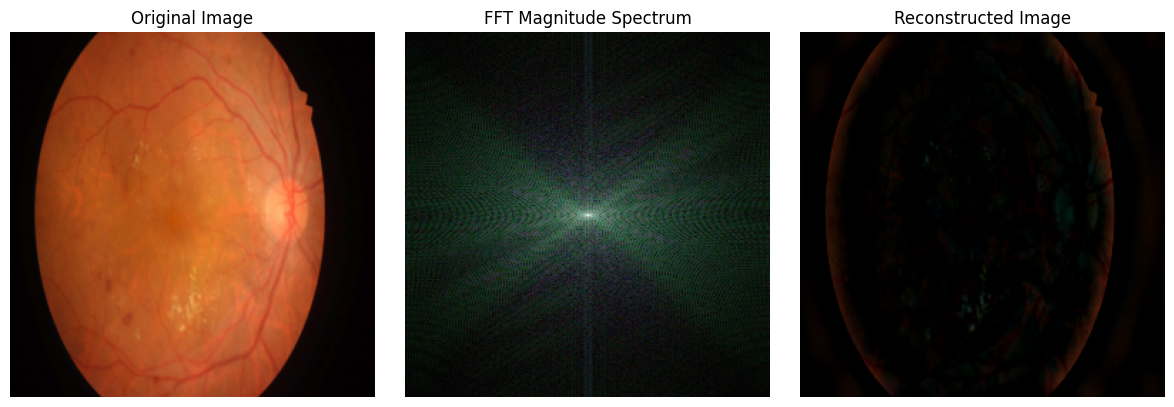

In [127]:
# Example: Low-pass filtering
processor = FourierProcessor(filter_type="highpass", radius_ratio=0.05)
original, magnitude, reconstructed = processor.process(img)
processor.visualize(original, magnitude, reconstructed)

# Try high-pass filtering too!
# processor = FourierProcessor(filter_type="highpass", radius_ratio=0.2)
